<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Acknowledgements" data-toc-modified-id="Acknowledgements-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Acknowledgements</a></span></li><li><span><a href="#Prepare-data-and-model" data-toc-modified-id="Prepare-data-and-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Prepare data and model</a></span></li><li><span><a href="#Customer-segmentation" data-toc-modified-id="Customer-segmentation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Customer segmentation</a></span></li><li><span><a href="#Customer-segmentation-using-Word2Vec-without-metadata" data-toc-modified-id="Customer-segmentation-using-Word2Vec-without-metadata-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Customer segmentation using Word2Vec without metadata</a></span></li></ul></div>

# Acknowledgements
Thanks to the tutorial: https://www.kaggle.com/c/word2vec-nlp-tutorial/overview/part-3-more-fun-with-word-vectors

# Prepare data and model

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re

import nltk
import nltk.data
nltk.download('stopwords')
from nltk.corpus import stopwords # Import the stop word list



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/daviderickson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def load_reviews(size='small'): 
    if size == 'small':
        filename = r'../../data/small-review.json'
    elif size == 'intermediate':
        filename = r'../../data/intermediate-review.json'
    elif size == 'full':
        filename = r'../../data/review.json'
    new_list = []
    for line in open(filename):
       new_list.append(json.loads(line))
    return pd.DataFrame.from_records(new_list)

dfreviews = load_reviews(size='intermediate')

In [3]:
dfreviews.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,ujmEBvifdJM6h6RLv4wQIg,0,2013-05-07 04:34:36,1,Q1sbwvVQXV2734tPgoKj4Q,1.0,Total bill for this horrible service? Over $8G...,6,hG7b0MtEbXx5QzbzE6C_VA
1,NZnhc2sEQy3RmzKTZnqtwQ,0,2017-01-14 21:30:33,0,GJXCdrto3ASJOqKeVWPi6Q,5.0,I *adore* Travis at the Hard Rock's new Kelly ...,0,yXQM5uF2jS6es16SJzNHfg
2,WTqjgwHlXbSFevF32_DJVw,0,2016-11-09 20:09:03,0,2TzJjDVDEuAW6MR5Vuc1ug,5.0,I have to say that this office really has it t...,3,n6-Gk65cPZL6Uz8qRm3NYw
3,ikCg8xy5JIg_NGPx-MSIDA,0,2018-01-09 20:56:38,0,yi0R0Ugj_xUx_Nek0-_Qig,5.0,Went in for a lunch. Steak sandwich was delici...,0,dacAIZ6fTM6mqwW5uxkskg
4,b1b1eb3uo-w561D0ZfCEiQ,0,2018-01-30 23:07:38,0,11a8sVPMUFtaC7_ABRkmtw,1.0,Today was my second out of three sessions I ha...,7,ssoyf2_x0EQMed6fgHeMyQ


In [4]:
dfreviews.columns

Index(['business_id', 'cool', 'date', 'funny', 'review_id', 'stars', 'text',
       'useful', 'user_id'],
      dtype='object')

In [5]:
dfreviews['text'][0]

'Total bill for this horrible service? Over $8Gs. These crooks actually had the nerve to charge us $69 for 3 pills. I checked online the pills can be had for 19 cents EACH! Avoid Hospital ERs at all costs.'

In [6]:
# For simplicity, drop anything that isn't a letter
# Numbers and symbols may have interesting meaning and could be explore later

def lettersOnly(string):
    return re.sub("[^a-zA-Z]", " ", string) 

dfreviews['text'] = dfreviews['text'].apply(lettersOnly)


In [7]:
dfreviews['text'][0]

'Total bill for this horrible service  Over   Gs  These crooks actually had the nerve to charge us     for   pills  I checked online the pills can be had for    cents EACH  Avoid Hospital ERs at all costs '

In [8]:
def review_to_wordlist(string, remove_stopwords=False):
    string = re.sub("[^a-zA-Z]", " ", string) # keep only letters. more complex model possible later
    words =  string.lower().split() # make everything lowercase. split into words
    if remove_stopwords:
        stops = set(stopwords.words('english')) # create a fast lookup for stopwords
        words = [w for w in words if not w in stops] # remove stopwords
    return( words) # return a list of words
    
# dfreviews['text'] = dfreviews['text'].apply(review_to_words) # apply to reviews in dataframe


In [9]:
# Word2Vec expects single sentences, each one as a list of words

# Load the punkt tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

# Define a function to split a review into parsed sentences
def review_to_sentences( review, tokenizer, remove_stopwords=False ):
    # Function to split a review into parsed sentences. Returns a 
    # list of sentences, where each sentence is a list of words
    #
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(review.strip())
    #
    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            sentences.append( review_to_wordlist( raw_sentence, \
              remove_stopwords ))
    #
    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences

In [10]:
sentences = []  # Initialize an empty list of sentences

print("Parsing sentences")
for review in dfreviews["text"]:
    sentences += review_to_sentences(review, tokenizer)

Parsing sentences


In [11]:
# Import the built-in logging module and configure it so that Word2Vec 
# creates nice output messages
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
from gensim.models import word2vec
print("Training model...")
model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
model_name = "300features_40minwords_10context"
model.save(model_name)

2019-11-26 21:02:17,863 : INFO : 'pattern' package not found; tag filters are not available for English
2019-11-26 21:02:17,870 : INFO : collecting all words and their counts
2019-11-26 21:02:17,871 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types


Training model...


2019-11-26 21:02:18,103 : INFO : PROGRESS: at sentence #10000, processed 1088334 words, keeping 25539 word types
2019-11-26 21:02:18,495 : INFO : PROGRESS: at sentence #20000, processed 2172597 words, keeping 35463 word types
2019-11-26 21:02:18,771 : INFO : PROGRESS: at sentence #30000, processed 3251616 words, keeping 42649 word types
2019-11-26 21:02:19,048 : INFO : PROGRESS: at sentence #40000, processed 4373996 words, keeping 48893 word types
2019-11-26 21:02:19,239 : INFO : PROGRESS: at sentence #50000, processed 5471587 words, keeping 53964 word types
2019-11-26 21:02:19,430 : INFO : PROGRESS: at sentence #60000, processed 6570064 words, keeping 58362 word types
2019-11-26 21:02:19,681 : INFO : PROGRESS: at sentence #70000, processed 7667364 words, keeping 62704 word types
2019-11-26 21:02:19,947 : INFO : PROGRESS: at sentence #80000, processed 8768955 words, keeping 66443 word types
2019-11-26 21:02:20,172 : INFO : PROGRESS: at sentence #90000, processed 9872097 words, keeping 

2019-11-26 21:03:03,898 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-11-26 21:03:03,906 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-11-26 21:03:03,907 : INFO : EPOCH - 4 : training on 10978770 raw words (7804495 effective words) took 10.0s, 779930 effective words/s
2019-11-26 21:03:04,917 : INFO : EPOCH 5 - PROGRESS: at 9.74% examples, 754694 words/s, in_qsize 7, out_qsize 0
2019-11-26 21:03:05,924 : INFO : EPOCH 5 - PROGRESS: at 19.98% examples, 768807 words/s, in_qsize 7, out_qsize 0
2019-11-26 21:03:06,924 : INFO : EPOCH 5 - PROGRESS: at 30.35% examples, 778026 words/s, in_qsize 7, out_qsize 0
2019-11-26 21:03:07,930 : INFO : EPOCH 5 - PROGRESS: at 40.38% examples, 782833 words/s, in_qsize 7, out_qsize 0
2019-11-26 21:03:08,931 : INFO : EPOCH 5 - PROGRESS: at 50.22% examples, 779319 words/s, in_qsize 7, out_qsize 0
2019-11-26 21:03:09,935 : INFO : EPOCH 5 - PROGRESS: at 60.23% examples, 779168 words/s, in_qsize 7, out_qsize 0
20

In [12]:
model.most_similar('pizza')

/Users/daviderickson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('crust', 0.7113319635391235),
 ('pepperoni', 0.6830288171768188),
 ('pizzas', 0.6829661726951599),
 ('margherita', 0.6293174028396606),
 ('calzone', 0.6170080304145813),
 ('slice', 0.5470247268676758),
 ('mozzarella', 0.5415903329849243),
 ('lasagna', 0.5314947366714478),
 ('subs', 0.5292935371398926),
 ('dough', 0.5282620191574097)]

In [13]:
model.most_similar('service')

/Users/daviderickson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('waitstaff', 0.5270807147026062),
 ('staff', 0.4669780731201172),
 ('hospitality', 0.4270775318145752),
 ('communication', 0.4259728193283081),
 ('servers', 0.4120202660560608),
 ('consistently', 0.4095593988895416),
 ('value', 0.3936384916305542),
 ('presentation', 0.3934309482574463),
 ('experience', 0.3811669647693634),
 ('bartenders', 0.380217969417572)]

In [14]:
model.most_similar('bad')

/Users/daviderickson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('terrible', 0.6222255229949951),
 ('horrible', 0.5659447908401489),
 ('good', 0.5543625950813293),
 ('poor', 0.5480709671974182),
 ('awful', 0.5354901552200317),
 ('disappointing', 0.48741209506988525),
 ('greatest', 0.47903355956077576),
 ('alright', 0.4585767090320587),
 ('subpar', 0.4503645598888397),
 ('acceptable', 0.4480467736721039)]

In [15]:
import numpy as np  # Make sure that numpy is imported

def makeFeatureVec(words, model, num_features):
    # Function to average all of the word vectors in a given
    # paragraph
    #
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,),dtype="float32")
    #
    nwords = 0.
    # 
    # WV.Index2word is a list that contains the names of the words in 
    # the model's vocabulary. Convert it to a set, for speed 
    index2word_set = set(model.wv.index2word)
    #
    # Loop over each word in the review and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model[word])
    # 
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec,nwords)
    return featureVec


def getAvgFeatureVecs(reviews, model, num_features):
    # Given a set of reviews (each one a list of words), calculate 
    # the average feature vector for each one and return a 2D numpy array 
    # 
    # Initialize a counter
    counter = int(0.)
    # 
    # Preallocate a 2D numpy array, for speed
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    # 
    # Loop through the reviews
    for review in reviews:
       #
       # Print a status message every 1000th review
       if counter%1000. == 0.:
           print ("Review %d of %d" % (counter, len(reviews)))
       # 
       # Call the function (defined above) that makes average feature vectors
       reviewFeatureVecs[counter] = makeFeatureVec(review, model, \
           num_features)
       #
       # Increment the counter
       counter = counter + 1
    return reviewFeatureVecs

In [16]:
# ****************************************************************
# Calculate average feature vectors
# using the functions we defined above. Notice that we now use stop word
# removal.

clean_reviews = []
for review in dfreviews["text"]:
    clean_reviews.append( review_to_wordlist( review, \
        remove_stopwords=True ))

reviewDataVecs = getAvgFeatureVecs( clean_reviews, model, num_features )

Review 0 of 100000


/Users/daviderickson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Review 1000 of 100000
Review 2000 of 100000
Review 3000 of 100000
Review 4000 of 100000
Review 5000 of 100000
Review 6000 of 100000
Review 7000 of 100000
Review 8000 of 100000


/Users/daviderickson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


Review 9000 of 100000
Review 10000 of 100000
Review 11000 of 100000
Review 12000 of 100000
Review 13000 of 100000
Review 14000 of 100000
Review 15000 of 100000
Review 16000 of 100000
Review 17000 of 100000
Review 18000 of 100000
Review 19000 of 100000
Review 20000 of 100000
Review 21000 of 100000
Review 22000 of 100000
Review 23000 of 100000
Review 24000 of 100000
Review 25000 of 100000
Review 26000 of 100000
Review 27000 of 100000
Review 28000 of 100000
Review 29000 of 100000
Review 30000 of 100000
Review 31000 of 100000
Review 32000 of 100000
Review 33000 of 100000
Review 34000 of 100000
Review 35000 of 100000
Review 36000 of 100000
Review 37000 of 100000
Review 38000 of 100000
Review 39000 of 100000
Review 40000 of 100000
Review 41000 of 100000
Review 42000 of 100000
Review 43000 of 100000
Review 44000 of 100000
Review 45000 of 100000
Review 46000 of 100000
Review 47000 of 100000
Review 48000 of 100000
Review 49000 of 100000
Review 50000 of 100000
Review 51000 of 100000
Review 52000

# Customer segmentation

In [17]:
# Avg Over users

In [18]:
# Clustering of Word2Vec
# K means


In [19]:
reviewDataVecs.shape[1]

300

In [20]:
# train_data_features has tfidf featues
# Add other data to each review (stars, useful, ...)
# GroupBy User and avg across each review
# Cluster users using K-means
# Interpret user clusters


# Add non-text data back to feature matrix
review_features = ['cool', 'funny', 'stars', 'useful', 'user_id']
all_features_labels = ['w2v{}'.format(idx) for idx in range(reviewDataVecs.shape[1])] + review_features
all_features = np.append(reviewDataVecs, dfreviews[review_features].to_numpy(), 1)


In [21]:
# GroupBy User and avg across each review
all_features_df = pd.DataFrame(data=all_features, columns=all_features_labels)
all_features_df_tmp = all_features_df.iloc[:,:-1].astype('float64')
all_features_df_tmp['user_id'] = all_features_df['user_id']
all_features_df = all_features_df_tmp
del all_features_df_tmp
all_features_User = all_features_df.groupby(by='user_id').mean()

In [22]:
all_features_User.head()

,w2v0,w2v1,w2v2,w2v3,w2v4,w2v5,w2v6,w2v7,w2v8,w2v9,...,w2v294,w2v295,w2v296,w2v297,w2v298,w2v299,cool,funny,stars,useful
user_id,,,,,,,,,,,,,,,,,,,,,
---1lKK3aKOuomHnwAkAow,-0.006515,0.012793,0.019727,0.015488,-0.001755,0.006182,-0.002894,0.022111,-0.014236,-0.024575,...,0.020014,0.001835,0.000584,0.007404,-0.000934,-0.002110,1.0,0.0,5.0,2.5
--2HUmLkcNHZp0xw6AMBPg,0.026612,-0.013419,-0.020137,0.014769,0.003167,-0.011115,-0.006558,0.033642,-0.012830,-0.006101,...,-0.001170,0.001203,0.001086,-0.014323,-0.016657,-0.007134,0.0,0.0,4.5,0.0
--3WaS23LcIXtxyFULJHTA,0.015951,0.004061,0.012477,0.013037,0.002660,-0.014471,0.001145,0.017760,-0.017670,0.002504,...,0.024509,-0.000754,-0.006477,0.003988,0.005234,0.005901,1.0,1.0,5.0,4.0
--7oh57FmI8_IHX0Q4n-Wg,0.013409,-0.028875,-0.012340,0.021357,0.009772,-0.010750,0.037046,0.020469,0.000699,0.013250,...,0.025914,0.029723,0.001659,0.010866,-0.035761,0.006974,0.0,0.0,5.0,1.0
--HCoE1ghaAlcaAfshICgw,0.005649,-0.004992,-0.001649,0.021196,-0.003716,-0.016755,-0.004526,0.029018,-0.036802,-0.005006,...,0.045466,-0.013555,-0.030858,0.010270,0.005729,-0.012974,0.0,0.0,4.0,0.0


In [23]:
all_features_User.describe()

,w2v0,w2v1,w2v2,w2v3,w2v4,w2v5,w2v6,w2v7,w2v8,w2v9,...,w2v294,w2v295,w2v296,w2v297,w2v298,w2v299,cool,funny,stars,useful
count,80003.000000,80003.000000,80003.000000,80003.000000,80003.000000,80003.000000,80003.000000,80003.000000,80003.000000,80003.000000,...,80003.000000,80003.000000,80003.000000,80003.000000,80003.000000,80003.000000,80013.000000,80013.000000,80013.000000,80013.000000
mean,0.015417,-0.009175,0.006423,0.023368,-0.002426,-0.002016,-0.002903,0.013829,-0.013899,-0.003438,...,0.020583,0.000872,-0.008179,0.004795,-0.010051,0.001875,0.386984,0.336523,3.729682,1.083316
std,0.016643,0.015037,0.014191,0.012983,0.012750,0.013511,0.016457,0.017670,0.014664,0.012898,...,0.015670,0.014781,0.013991,0.017375,0.016605,0.015654,1.464536,1.243912,1.466585,2.393015
min,-0.066943,-0.091057,-0.093607,-0.103097,-0.110266,-0.082791,-0.118211,-0.095289,-0.149294,-0.082132,...,-0.076815,-0.108868,-0.126873,-0.112730,-0.112356,-0.095039,0.000000,0.000000,1.000000,0.000000
25%,0.004943,-0.018615,-0.002053,0.015348,-0.009399,-0.010174,-0.013005,0.003167,-0.023255,-0.011440,...,0.011378,-0.008711,-0.016890,-0.005395,-0.019524,-0.008009,0.000000,0.000000,3.000000,0.000000
50%,0.015444,-0.008981,0.006712,0.023562,-0.002149,-0.001749,-0.003739,0.013782,-0.014221,-0.003628,...,0.020930,-0.000471,-0.008704,0.005348,-0.009084,0.001372,0.000000,0.000000,4.000000,0.000000
75%,0.025795,0.000379,0.015361,0.031578,0.004935,0.006419,0.006594,0.024231,-0.004885,0.004358,...,0.030260,0.009075,-0.000031,0.015710,0.000249,0.010825,0.000000,0.000000,5.000000,1.000000
max,0.104744,0.075189,0.083600,0.106771,0.075295,0.082397,0.112255,0.156502,0.109780,0.111035,...,0.104876,0.077185,0.074614,0.081569,0.096399,0.123708,94.000000,74.000000,5.000000,101.000000


In [24]:
all_features_User.dropna(axis=0, inplace=True) # There are 10 rows with NANs

In [25]:
# Cluster users using K-means
from sklearn.cluster import KMeans

max_clusters = 10
kmeans_cost = []
for num_clusters in range(1,max_clusters):
    k_means_clutering = KMeans(n_clusters=num_clusters)
    k_means_clutering.fit(all_features_User)
    kmeans_cost.append(k_means_clutering.inertia_)
    

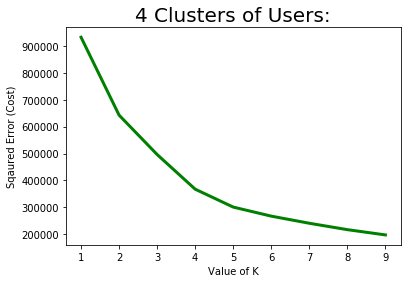

In [26]:
# Determine the best value of K to use (the number of clusters)
# plot the cost against K values 
plt.plot(range(1, max_clusters), kmeans_cost, color ='g', linewidth ='3') 
plt.title('4 Clusters of Users:', fontsize=20)
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 

In [40]:
# Cluster users using K-means
# Interpret user clusters

num_clusters = 4
k_means_clutering = KMeans(n_clusters=num_clusters)
k_means_clutering.fit(all_features_User)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [41]:
user_cluster_centers_df = pd.DataFrame(data=k_means_clutering.cluster_centers_, columns=all_features_User.columns)
user_cluster_centers_df.head()

,w2v0,w2v1,w2v2,w2v3,w2v4,w2v5,w2v6,w2v7,w2v8,w2v9,...,w2v294,w2v295,w2v296,w2v297,w2v298,w2v299,cool,funny,stars,useful
0,0.015188,-0.008921,0.003888,0.021837,-0.001780,-0.003382,0.000387,0.016166,-0.011615,-0.002229,...,0.019344,0.003802,-0.005668,0.007816,-0.013809,0.006695,0.270005,0.151550,4.660690,0.594716
1,0.016635,-0.010337,0.010866,0.026396,-0.003764,0.000557,-0.009141,0.009065,-0.018528,-0.005671,...,0.022981,-0.004426,-0.013249,-0.001298,-0.003058,-0.007809,0.153435,0.299456,1.858661,0.891334
2,0.010421,-0.004863,0.009175,0.019185,-0.001152,-0.000491,-0.007974,0.016395,-0.011748,-0.005698,...,0.018592,-0.003107,-0.008629,0.000611,-0.003392,0.004763,27.714180,18.988280,3.740073,35.071661
3,0.011205,-0.005598,0.011854,0.024744,-0.002647,-0.000159,-0.007131,0.012652,-0.015186,-0.005327,...,0.021970,-0.004431,-0.009653,0.003068,-0.004479,-0.001321,2.629587,2.459841,3.125700,7.579949


In [29]:
print('The most similar words to the avg vector describing each user cluster:\n')
for cluster in range(len(user_cluster_centers_df)):
    print('Cluster {}'.format(cluster))
    display(
        model.wv.similar_by_vector(user_cluster_centers_df.iloc[cluster,:300].values, topn=10)
    )

The most similar words to the avg vector describing each user cluster:

Cluster 0


[('good', 0.47709816694259644),
 ('great', 0.473907470703125),
 ('delish', 0.45719754695892334),
 ('food', 0.45139822363853455),
 ('delicious', 0.44739991426467896),
 ('awesome', 0.44475752115249634),
 ('attentive', 0.44467678666114807),
 ('yummy', 0.4440932273864746),
 ('bomb', 0.4433334469795227),
 ('pb', 0.44046637415885925)]

Cluster 1


[('plug', 0.4780874252319336),
 ('approval', 0.459347665309906),
 ('device', 0.4587934613227844),
 ('honeymoon', 0.4555972218513489),
 ('condo', 0.4538918137550354),
 ('purse', 0.45325374603271484),
 ('exception', 0.4524080157279968),
 ('bridge', 0.4479495882987976),
 ('residence', 0.43689361214637756),
 ('camera', 0.43514832854270935)]

Cluster 2


[('order', 0.455502986907959),
 ('exception', 0.4219696521759033),
 ('it', 0.4112473726272583),
 ('bill', 0.4090920090675354),
 ('food', 0.3837944269180298),
 ('problem', 0.38288813829421997),
 ('excuse', 0.382709264755249),
 ('inconvenience', 0.3800278604030609),
 ('money', 0.3746493458747864),
 ('fault', 0.37418150901794434)]

Cluster 3


[('attraction', 0.5253591537475586),
 ('dot', 0.5159540176391602),
 ('era', 0.4927293062210083),
 ('sunset', 0.48802998661994934),
 ('quebec', 0.4857044816017151),
 ('church', 0.48153284192085266),
 ('ontario', 0.4812454581260681),
 ('feast', 0.4759010076522827),
 ('captain', 0.4715045988559723),
 ('bridge', 0.4702710807323456)]

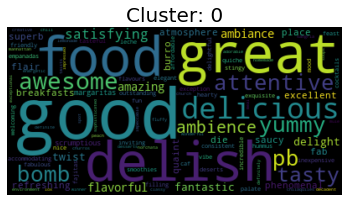

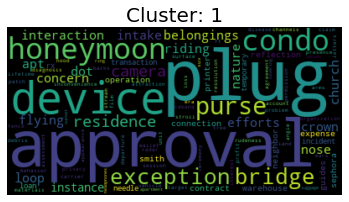

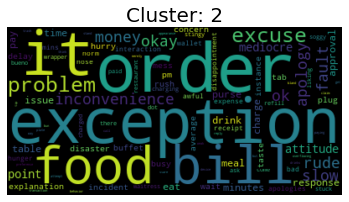

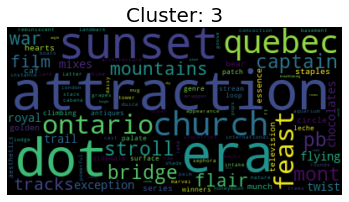

In [30]:
from wordcloud import WordCloud

for cluster in range(len(user_cluster_centers_df)):
#     series = user_cluster_centers_df.iloc[cluster,:-4] #Use relevant row, drop non-word cols
#     wc_dict = series.to_dict()
    series = model.wv.similar_by_vector(user_cluster_centers_df.iloc[cluster,:-4].values, topn=100)
    wc_dict = {}
    for key, val in series:
        wc_dict[key] = val
    wordcloud = WordCloud().generate_from_frequencies(wc_dict)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Cluster: {}'.format(cluster), fontsize=20)
    plt.axis('off')
    plt.show()
    

# Customer segmentation using Word2Vec without metadata

In [31]:
# Cluster users using K-means
from sklearn.cluster import KMeans

max_clusters = 10
kmeans_cost = []
for num_clusters in range(1,max_clusters):
    k_means_clutering = KMeans(n_clusters=num_clusters)
    k_means_clutering.fit(all_features_User.iloc[:,:-4])
    kmeans_cost.append(k_means_clutering.inertia_)
    

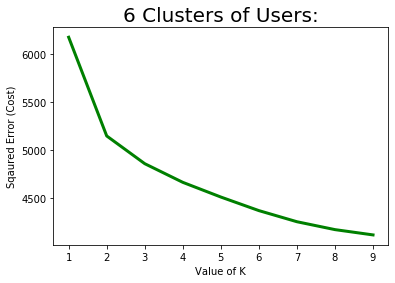

In [32]:
# Determine the best value of K to use (the number of clusters)
# plot the cost against K values 
plt.plot(range(1, max_clusters), kmeans_cost, color ='g', linewidth ='3') 
plt.title('6 Clusters of Users:', fontsize=20)
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 

In [42]:
# Cluster users using K-means
# Interpret user clusters

num_clusters = 6
k_means_clutering = KMeans(n_clusters=num_clusters)
k_means_clutering.fit(all_features_User.iloc[:,:-4])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [43]:
len(all_features_User.columns)

304

In [46]:
user_cluster_centers_df = pd.DataFrame(data=k_means_clutering.cluster_centers_, columns=all_features_User.iloc[:,:-4].columns)
user_cluster_centers_df.head()

,w2v0,w2v1,w2v2,w2v3,w2v4,w2v5,w2v6,w2v7,w2v8,w2v9,...,w2v290,w2v291,w2v292,w2v293,w2v294,w2v295,w2v296,w2v297,w2v298,w2v299
0,0.001038,0.000460,0.010384,0.024828,-0.010673,0.004630,-0.010711,0.013527,-0.010115,-0.011811,...,0.005129,0.004968,-0.008395,0.002270,0.022275,0.003456,-0.001551,0.009456,-0.010051,0.009419
1,0.027082,-0.013459,0.002718,0.013370,0.003140,-0.011566,-0.004494,0.026128,-0.015845,0.000930,...,0.010310,-0.010371,-0.022959,0.004291,0.013645,-0.002812,-0.008363,-0.011513,-0.006155,-0.001043
2,0.017364,-0.012455,0.005179,0.023428,-0.002640,-0.002311,-0.006747,0.012217,-0.015153,-0.003528,...,0.002949,0.001088,-0.005970,0.005051,0.024695,-0.002169,-0.013132,0.000713,-0.006932,-0.003633
3,0.018343,-0.014258,-0.003666,0.024741,-0.002160,-0.001652,0.006886,0.008864,-0.006834,-0.002316,...,0.021119,-0.014392,-0.012437,-0.002206,0.019751,0.012807,-0.006552,0.012017,-0.022527,0.011672
4,0.013384,-0.005787,0.008690,0.029492,-0.001211,0.001421,0.008704,0.011493,-0.010971,-0.001027,...,0.024864,-0.000456,0.001269,-0.003326,0.019917,0.005252,-0.001361,0.020748,-0.019215,0.009451


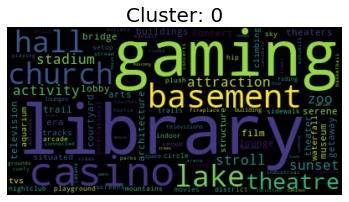

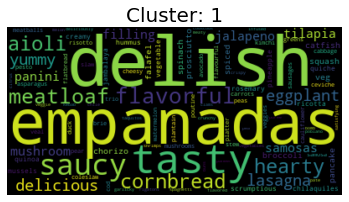

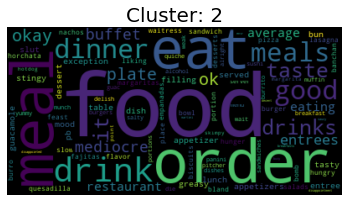

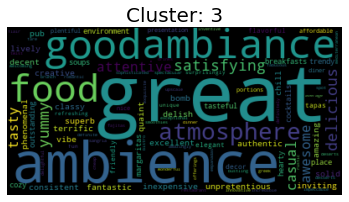

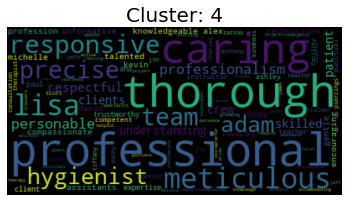

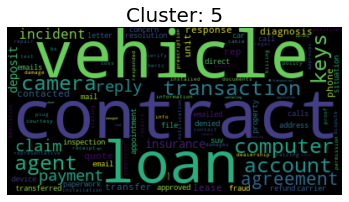

In [47]:
from wordcloud import WordCloud

for cluster in range(len(user_cluster_centers_df)):
#     series = user_cluster_centers_df.iloc[cluster,:-4] #Use relevant row, drop non-word cols
#     wc_dict = series.to_dict()
    series = model.wv.similar_by_vector(user_cluster_centers_df.iloc[cluster].values, topn=100)
    wc_dict = {}
    for key, val in series:
        wc_dict[key] = val
    wordcloud = WordCloud().generate_from_frequencies(wc_dict)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Cluster: {}'.format(cluster), fontsize=20)
    plt.axis('off')
    plt.show()
    

In [61]:
all_features_User[['cool', 'funny', 'useful', 'stars']].groupby(by=k_means_clutering.labels_).mean()

,cool,funny,useful,stars
0,0.727093,0.623156,1.472155,3.960397
1,0.396613,0.255967,0.775160,3.990667
2,0.467720,0.445244,1.115541,3.243440
3,0.223382,0.111753,0.442209,4.523417
4,0.272084,0.148362,0.921752,4.785776
5,0.226953,0.412909,1.892717,2.310513


In [65]:
user_cluster_centers_df.merge(right=all_features_User[['cool', 'funny', 'useful', 'stars']].groupby(by=k_means_clutering.labels_).mean(), left_index=True, right_index=True)

,w2v0,w2v1,w2v2,w2v3,w2v4,w2v5,w2v6,w2v7,w2v8,w2v9,...,w2v294,w2v295,w2v296,w2v297,w2v298,w2v299,cool,funny,useful,stars
0,0.001038,0.000460,0.010384,0.024828,-0.010673,0.004630,-0.010711,0.013527,-0.010115,-0.011811,...,0.022275,0.003456,-0.001551,0.009456,-0.010051,0.009419,0.727093,0.623156,1.472155,3.960397
1,0.027082,-0.013459,0.002718,0.013370,0.003140,-0.011566,-0.004494,0.026128,-0.015845,0.000930,...,0.013645,-0.002812,-0.008363,-0.011513,-0.006155,-0.001043,0.396613,0.255967,0.775160,3.990667
2,0.017364,-0.012455,0.005179,0.023428,-0.002640,-0.002311,-0.006747,0.012217,-0.015153,-0.003528,...,0.024695,-0.002169,-0.013132,0.000713,-0.006932,-0.003633,0.467720,0.445244,1.115541,3.243440
3,0.018343,-0.014258,-0.003666,0.024741,-0.002160,-0.001652,0.006886,0.008864,-0.006834,-0.002316,...,0.019751,0.012807,-0.006552,0.012017,-0.022527,0.011672,0.223382,0.111753,0.442209,4.523417
4,0.013384,-0.005787,0.008690,0.029492,-0.001211,0.001421,0.008704,0.011493,-0.010971,-0.001027,...,0.019917,0.005252,-0.001361,0.020748,-0.019215,0.009451,0.272084,0.148362,0.921752,4.785776
5,0.008022,-0.004013,0.018402,0.028487,-0.003593,0.001977,-0.007723,0.007946,-0.022192,-0.005005,...,0.022934,-0.007591,-0.012760,0.007936,0.000251,-0.008130,0.226953,0.412909,1.892717,2.310513
